In [5]:
import numpy as np
from scipy.stats import multivariate_normal, chi2


def nearest_positive_definite(matrix):
    """
    Convert a symmetric matrix to the nearest positive definite matrix.
    """
    # 행렬 대칭화
    sym_matrix = (matrix + matrix.T) / 2
    # 고유값 분해
    eigvals, eigvecs = np.linalg.eigh(sym_matrix)
    # 음수 고유값을 작은 양수로 대체
    eigvals[eigvals < 0] = 1e-10
    # 고유값과 고유벡터로 행렬 복원
    positive_definite_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T
    return positive_definite_matrix

# 데이터 생성 함수
def generate_synthetic_data_real(T=200, phi1=0.5, phi2=-0.5, nu1=5, nu2=10):
    # 상관 계수 행렬 rho 생성
    rho = np.random.uniform(0, 1, size=(5, 5))
    rho=(rho+rho.T)/2
    np.fill_diagonal(rho, 1)

    rho= nearest_positive_definite(rho)


    # 랜덤으로 s_i 값 생성 (s_i는 0.3~0.5 사이에서 샘플링)
    s = np.random.uniform(0.3, 0.5, size=5)

    # 공분산 행렬 Σ 생성
    cov_matrix = np.zeros((5, 5))
    for i in range(5):
        for j in range(5):
            cov_matrix[i, j] = (s[i] / 255) * s[j] * rho[i, j]

    # 다변량 정규분포에서 u_t 샘플링
    u_t = multivariate_normal.rvs(mean=np.zeros(5), cov=cov_matrix, size=T)

    # 카이제곱 분포 샘플링
    v1_t = chi2.rvs(df=nu1, size=T)
    v2_t = chi2.rvs(df=nu2, size=T)

    # κ4, κ5 및 γ4, γ5 범위 내에서 샘플링
    kappa4 = np.random.uniform(0.08, 0.12)
    kappa5 = np.random.uniform(0.08, 0.12)
    gamma4 = np.random.uniform(0.03, 0.07)
    gamma5 = np.random.uniform(0.03, 0.07)

    # β4, β5 범위 내에서 샘플링
    beta4 = np.random.uniform(0.825, 0.875)
    beta5 = np.random.uniform(0.825, 0.875)

    # 초기화
    delta_p = np.zeros((T, 5))
    sigma4_t = np.zeros(T)
    sigma5_t = np.zeros(T)
    sigma4_t[0] = 1  # 초기값 설정
    sigma5_t[0] = 1

    for t in range(1, T):
        # 분포 1 (정규분포 기반)
        delta_p[t, 0] = u_t[t, 0]

        # 분포 2 (AR(1) 기반)
        delta_p[t, 1] = phi1 * delta_p[t - 1, 1] + u_t[t, 1]

        # 분포 3 (AR(1) 기반, 다른 계수)
        delta_p[t, 2] = phi2 * delta_p[t - 1, 2] + u_t[t, 2]

        # 분포 4 (GARCH(1,1) 기반)
        sigma4_t[t] = gamma4 + kappa4 * delta_p[t - 1, 3]**2 + beta4 * sigma4_t[t - 1]
        eta1_t = u_t[t, 3] / np.sqrt(v1_t[t] / nu1)
        delta_p[t, 3] = np.sqrt(sigma4_t[t]) * eta1_t

        # 분포 5 (GARCH(1,1) 기반)
        sigma5_t[t] = gamma5 + kappa5 * delta_p[t - 1, 4]**2 + beta5 * sigma5_t[t - 1]
        eta2_t = u_t[t, 4] / np.sqrt(v2_t[t] / nu2)
        delta_p[t, 4] = np.sqrt(sigma5_t[t]) * eta2_t

    return {
        "Normal Distribution": delta_p[:, 0],
        "AR(1) with phi1=0.5": delta_p[:, 1],
        "AR(1) with phi2=-0.5": delta_p[:, 2],
        "GARCH(1,1) with 5": delta_p[:, 3],
        "GARCH(1,1) with 10": delta_p[:, 4],
         }

# 데이터 생성
price_changes = generate_synthetic_data_real()



for dist_name, data in price_changes.items():
    print(f"Distribution: {dist_name}")
    print("Data (first 10 values):", data[:10])  # 첫 10개의 데이터만 출력
    print("Data Shape:", data.shape)  # 데이터의 크기 출력
    print("-" * 50)  # 구분선


Distribution: Normal Distribution
Data (first 10 values): [ 0.          0.03016431 -0.06332273 -0.00033829 -0.02979115 -0.00624047
 -0.0582854   0.02487048  0.0042538  -0.05893232]
Data Shape: (200,)
--------------------------------------------------
Distribution: AR(1) with phi1=0.5
Data (first 10 values): [ 0.          0.03150223 -0.02056899 -0.00918923 -0.02496356 -0.03614862
 -0.01753069 -0.01731437 -0.0033539  -0.01105006]
Data Shape: (200,)
--------------------------------------------------
Distribution: AR(1) with phi2=-0.5
Data (first 10 values): [ 0.          0.01443706 -0.05415885  0.03581447 -0.02749997 -0.00201653
 -0.04277209  0.05559502 -0.03777881 -0.04811759]
Data Shape: (200,)
--------------------------------------------------
Distribution: GARCH(1,1) with 5
Data (first 10 values): [ 0.          0.04940567 -0.07561641 -0.01014575 -0.03074018 -0.0199439
  0.07962196  0.01815064 -0.00782062 -0.0303321 ]
Data Shape: (200,)
-------------------------------------------------

In [6]:
def generate_price_levels(price_changes, initial_price=1):
    """
    각 분포별 가격 변화를 누적하여 가격 레벨을 생성합니다.
    Args:
        price_changes (dict): 분포별 가격 변화량 데이터.
        initial_price (float): 초기 가격 (기본값: 100).
    Returns:
        dict: 분포별 가격 레벨 데이터.
    """
    price_levels = {}
    for dist_name, changes in price_changes.items():
        # 누적 계산: P_t = P_{t-1} + Δp_t
        prices = np.cumsum(changes) + initial_price
        price_levels[dist_name] = prices
    return price_levels

# 가격 변화 데이터 생성
price_changes = generate_synthetic_data_real()

# 가격 계산
price_levels = generate_price_levels(price_changes)

# 결과 출력
for dist_name, prices in price_levels.items():
    print(f"Price levels for {dist_name}:")
    print("First 10 prices:", prices[:10])  # 첫 10개의 가격 출력
    print("Final price:", prices[-1])  # 최종 가격 출력
    print("-" * 50)



Price levels for Normal Distribution:
First 10 prices: [1.         1.03172853 1.03031093 1.01545757 1.01579027 1.04536353
 1.04505596 1.08697634 1.06072975 1.06259263]
Final price: 0.9066085157286023
--------------------------------------------------
Price levels for AR(1) with phi1=0.5:
First 10 prices: [1.         0.99383334 0.97923309 0.97655204 0.98503525 0.98850217
 0.9574834  0.94678682 0.93021548 0.90409855]
Final price: 0.9458971866924932
--------------------------------------------------
Price levels for AR(1) with phi2=-0.5:
First 10 prices: [1.         0.98615978 0.9795016  0.97365798 0.97709825 0.97740941
 0.95639412 0.951762   0.93377455 0.97708756]
Final price: 1.2918875837318518
--------------------------------------------------
Price levels for GARCH(1,1) with 5:
First 10 prices: [1.         0.96196314 0.96781846 0.97494963 0.98970558 0.97827473
 0.9638904  0.97971372 0.97360724 0.96981354]
Final price: 0.9186025304603076
------------------------------------------------

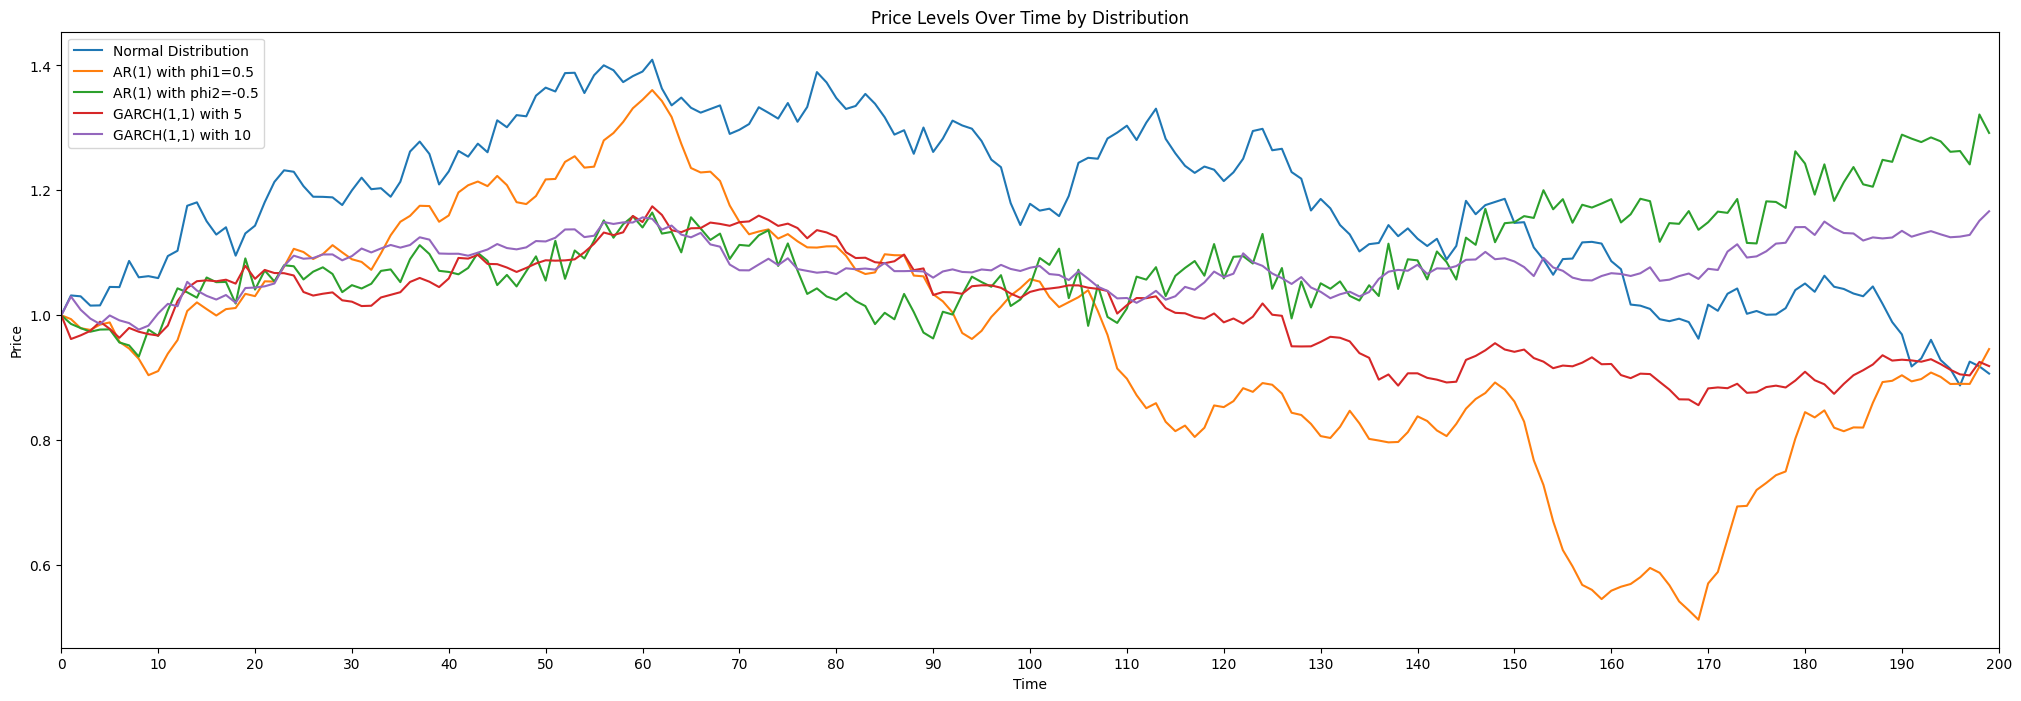

In [8]:
import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(25, 8))
for dist_name, prices in price_levels.items():
    plt.plot(prices, label=dist_name)
    
plt.xticks(range(0, 201, 10))
plt.xlim(0,200)

plt.legend()
plt.title("Price Levels Over Time by Distribution")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()


In [9]:
import torch
import numpy as np

# ✅ GPU 사용 설정 (CUDA가 없으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 배치 크기 설정


# 각 배치에 대해 같은 분포에서 새로운 데이터 생성
data_list = []
for _ in range(20000):
    data_dict = generate_synthetic_data_real(T=200, phi1=0.5, phi2=-0.5, nu1=5, nu2=10)
    data_values = list(data_dict.values())  # 리스트로 변환
    data_list.append(data_values)  # 리스트에 추가

# (1000, 5, 100) 형태로 변환 + ✅ GPU로 이동
data_real = torch.tensor(data_list, dtype=torch.float32).to(device)  # (1000, 5, 100)

print(data_real.shape)  # 출력: torch.Size([1000, 5, 100])



torch.Size([20000, 5, 200])


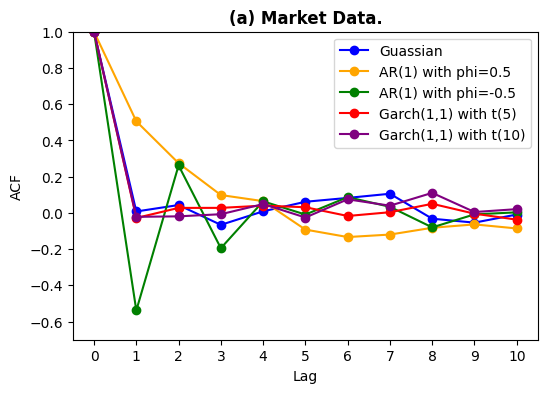

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

real_data = data_real.cpu().numpy()  # 

# ✅ (5,100) 데이터 중 하나 샘플링 (랜덤 선택)
sample_index_real = 589
sample_data_real= real_data[sample_index_real]  # (5,100)

# ✅ ACF 계산 (각 행별로)
lags = 10
acf_values_list = [acf(sample_data_real[i], nlags=lags, fft=True) for i in range(5)]

# ✅ ACF 그래프 출력 (5개 분포를 한 플롯에 표시)
plt.figure(figsize=(6, 4))
colors = ["blue", "orange", "green", "red", "purple"]
labels = ["Guassian", "AR(1) with phi=0.5", "AR(1) with phi=-0.5", "Garch(1,1) with t(5)", "Garch(1,1) with t(10)"]

for i in range(5):
    plt.plot(range(lags + 1), acf_values_list[i], marker="o", linestyle="-", color=colors[i], label=labels[i])

# ✅ 그래프 스타일 적용 (첨부된 사진과 유사하게 설정)
plt.xlabel("Lag")
plt.ylabel("ACF")
plt.xticks(range(lags + 1))
plt.ylim([-0.7, 1])
plt.title("(a) Market Data.", fontsize=12, fontweight="bold")

# ✅ 범례 추가 (5개 분포 표시)
plt.legend(loc="upper right")

# ✅ 그래프 표시
plt.show()


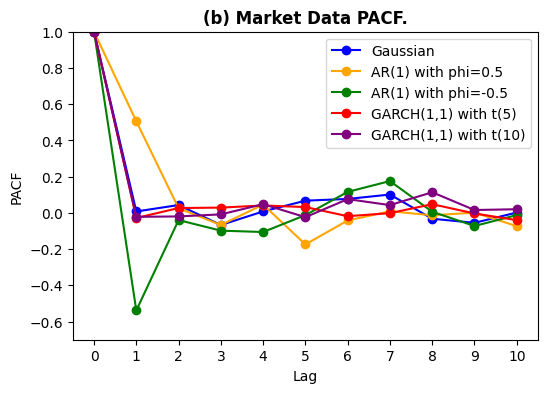

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf

# ✅ 실측 데이터 변환
real_data = data_real.cpu().numpy()  # (1000, 5, 100)

# ✅ 샘플 데이터 선택 (랜덤 인덱스)
sample_index_real = 589
sample_data_real = real_data[sample_index_real]  # (5,100)

# ✅ PACF 계산 (각 행별로)
lags = 10
pacf_values_list = [pacf(sample_data_real[i], nlags=lags, method="ywm") for i in range(5)]

# ✅ PACF 그래프 출력 (5개 분포를 한 플롯에 표시)
plt.figure(figsize=(6, 4))
colors = ["blue", "orange", "green", "red", "purple"]
labels = ["Gaussian", "AR(1) with phi=0.5", "AR(1) with phi=-0.5", "GARCH(1,1) with t(5)", "GARCH(1,1) with t(10)"]

for i in range(5):
    plt.plot(range(lags + 1), pacf_values_list[i], marker="o", linestyle="-", color=colors[i], label=labels[i])

# ✅ 그래프 스타일 적용
plt.xlabel("Lag")
plt.ylabel("PACF")
plt.xticks(range(lags + 1))
plt.ylim([-0.7, 1])
plt.title("(b) Market Data PACF.", fontsize=12, fontweight="bold")

# ✅ 범례 추가
plt.legend(loc="upper right")

# ✅ 그래프 표시
plt.show()
